# Q1

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

# Define transforms
train_transform = transforms.Compose([
    transforms.RandomRotation(5),
    transforms.RandomCrop(size=28, padding=2),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Download MNIST dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True,transform=train_transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True,transform=test_transform)

# Split into train, validation, and test datasets
trainset, valset = torch.utils.data.random_split(trainset, [50000, 10000])
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=32, shuffle=True)

# # Apply transforms to train, validation, and test datasets
# trainset.transform = train_transform
# valset.transform = test_transform
# testset.transform = test_transform


100%|██████████| 9912422/9912422 [00:00<00:00, 91519005.13it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 44210107.24it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 23835736.92it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4388511.58it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



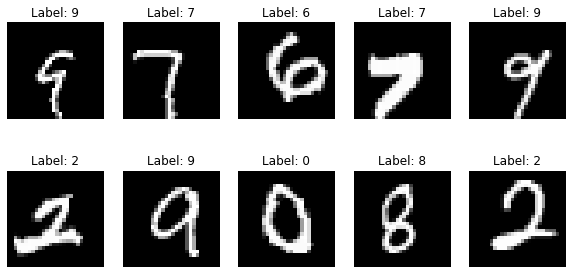

In [ ]:
import matplotlib.pyplot as plt
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    img, label = trainset[i]
    ax.imshow(img[0], cmap='gray')
    ax.set_title(f"Label: {classes[label]}")
    ax.axis('off')

plt.show()

In [ ]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Create an instance of the model
input_size = 28*28 # Size of MNIST images
hidden_size = 128
output_size = 10 # Number of classes
model = MLP(input_size, hidden_size, output_size)

# Print the number of trainable parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {num_params}")

Number of trainable parameters: 118282


Epoch 1/5 - Training Loss: 0.4144, Training Accuracy: 0.8689
Epoch 1/5 - Validation Loss: 0.2254, Validation Accuracy: 0.9317
Epoch 2/5 - Training Loss: 0.1878, Training Accuracy: 0.9410
Epoch 2/5 - Validation Loss: 0.1712, Validation Accuracy: 0.9489
Epoch 3/5 - Training Loss: 0.1521, Training Accuracy: 0.9524
Epoch 3/5 - Validation Loss: 0.1758, Validation Accuracy: 0.9462
Epoch 4/5 - Training Loss: 0.1338, Training Accuracy: 0.9580
Epoch 4/5 - Validation Loss: 0.1615, Validation Accuracy: 0.9525
Epoch 5/5 - Training Loss: 0.1191, Training Accuracy: 0.9626
Epoch 5/5 - Validation Loss: 0.1404, Validation Accuracy: 0.9591
Best validation accuracy of 0.9591 at epoch 5


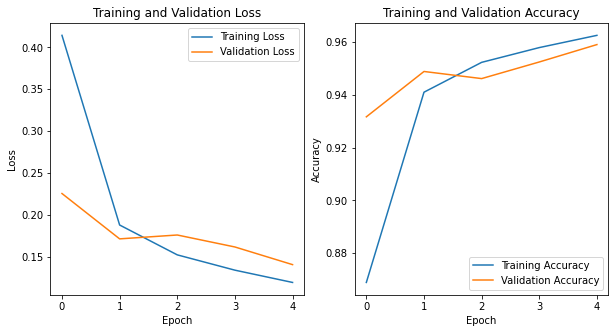

In [ ]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

best_acc = 0.0
best_epoch = 0


train_loss = []
train_acc = []
val_loss = []
val_acc = []

# Train the model for 5 epochs
for epoch in range(5):
    # Set the model to train mode
    model.train()

    # Define variables to keep track of the training loss and accuracy
    running_loss = 0.0
    running_corrects = 0

    # Loop over the training data in batches
    for inputs, labels in trainloader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Update the training loss and accuracy
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    # Calculate the average training loss and accuracy for this epoch
    epoch_loss = running_loss / len(trainloader.dataset)
    epoch_acc = running_corrects.double() / len(trainloader.dataset)

    # Append the training loss and accuracy to the lists
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)

    # Print the training loss and accuracy
    print(f"Epoch {epoch+1}/{5} - Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_acc:.4f}")

    # Set the model to evaluation mode
    model.eval()

    # Define variables to keep track of the validation loss and accuracy
    running_loss = 0.0
    running_corrects = 0

    # Loop over the validation data in batches
    for inputs, labels in valloader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Update the validation loss and accuracy
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    # Calculate the average validation loss and accuracy for this epoch
    epoch_loss = running_loss / len(valloader.dataset)
    epoch_acc = running_corrects.double() / len(valloader.dataset)

    # Append the validation loss and accuracy to the lists
    val_loss.append(epoch_loss)
    val_acc.append(epoch_acc)

    # Print the validation loss and accuracy
    print(f"Epoch {epoch+1}/{5} - Validation Loss: {epoch_loss:.4f}, Validation Accuracy: {epoch_acc:.4f}")

    # Save the model if it has the best validation accuracy so far
    if epoch_acc > best_acc:
        best_acc = epoch_acc
        best_epoch = epoch
        torch.save(model.state_dict(), 'best_model.pt')

# Print the best validation accuracy and the corresponding epoch number
print(f"Best validation accuracy of {best_acc:.4f} at epoch {best_epoch+1}")

# Plot the training and validation loss and accuracy curves
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.show()

#Q2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import math
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score

In [ ]:
data=pd.read_csv("/content/abalone.data")

In [ ]:
data

,M,0.455,0.365,0.095,0.514,0.2245,0.101,0.15,15
0,2,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
1,0,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
2,2,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
3,1,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
4,1,0.425,0.300,0.095,0.3515,0.1410,0.0775,0.1200,8
...,...,...,...,...,...,...,...,...,...
4171,0,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4172,2,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4173,2,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4174,0,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10


pre-proccessing

In [ ]:
le = preprocessing.LabelEncoder()
data['M']=le.fit_transform(data['M'])

In [ ]:
data

,M,0.455,0.365,0.095,0.514,0.2245,0.101,0.15,15
0,2,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
1,0,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
2,2,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
3,1,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
4,1,0.425,0.300,0.095,0.3515,0.1410,0.0775,0.1200,8
...,...,...,...,...,...,...,...,...,...
4171,0,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4172,2,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4173,2,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4174,0,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10


In [ ]:
y=data['15']
x=data.drop(['15'],axis=1)

In [ ]:
x

,M,0.455,0.365,0.095,0.514,0.2245,0.101,0.15
0,2,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700
1,0,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100
2,2,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550
3,1,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550
4,1,0.425,0.300,0.095,0.3515,0.1410,0.0775,0.1200
...,...,...,...,...,...,...,...,...
4171,0,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490
4172,2,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605
4173,2,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080
4174,0,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960


In [ ]:
y=np.array(y)
x=np.array(x)

In [ ]:
np.unique(y)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29])

In [ ]:
freq=np.zeros(30)
for i in y:
  freq[i]+=1
for i in np.unique(y):
  print("count of class",i,"=",freq[i])

count of class 1 = 1.0
count of class 2 = 1.0
count of class 3 = 15.0
count of class 4 = 57.0
count of class 5 = 115.0
count of class 6 = 259.0
count of class 7 = 391.0
count of class 8 = 568.0
count of class 9 = 689.0
count of class 10 = 634.0
count of class 11 = 487.0
count of class 12 = 267.0
count of class 13 = 203.0
count of class 14 = 126.0
count of class 15 = 102.0
count of class 16 = 67.0
count of class 17 = 58.0
count of class 18 = 42.0
count of class 19 = 32.0
count of class 20 = 26.0
count of class 21 = 14.0
count of class 22 = 6.0
count of class 23 = 9.0
count of class 24 = 2.0
count of class 25 = 1.0
count of class 26 = 1.0
count of class 27 = 2.0
count of class 29 = 1.0


Text(0.5, 0, 'class')

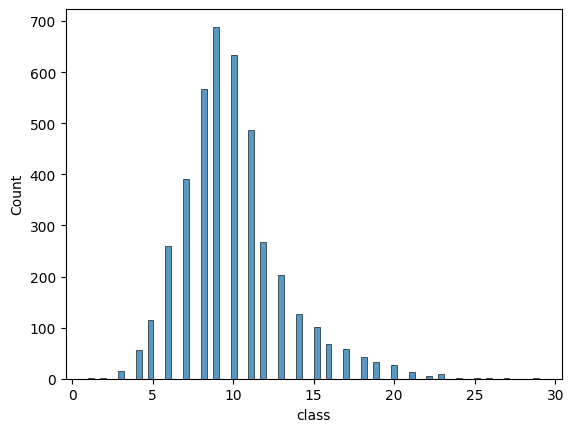

In [ ]:
plt.figure()
sns.histplot(y)
plt.xlabel("class")

binning the dataset

In [ ]:
for i in range(len(y)):
  if(y[i] <  9):
    y[i]=0
  elif(y[i]<11):
    y[i]=1
  else:
    y[i]=2

In [ ]:
freq=np.zeros(30)
for i in y:
  freq[i]+=1
for i in np.unique(y):
  print("count of class",i,"=",freq[i])

count of class 0 = 1407.0
count of class 1 = 1323.0
count of class 2 = 1446.0


In [ ]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3)

In [ ]:
x_train=x_train.T

In [ ]:
x_test=x_test.T

Multi Layer Perceptron from scratch

In [ ]:
class MLP():
  def __init__(self,iters,learning_rate,n_nodes,weights,activation_function):
    self.iters=iters
    self.a=learning_rate
    self.m=n_nodes
    self.fn=activation_function
    self.c=0
    self.n=0
    self.x=[]
    self.y=[]
    self.w1=[]
    self.b1=[]
    self.w2=[]
    self.b2=[]
    self.z1=[]
    self.a1=[]
    self.z2=[]
    self.a2=[]
    self.epoch_accs=[]
    self.wtype=weights

  def init_params(self):
    if(self.wtype=='random'):
      self.w1=np.random.rand(self.m,self.n)-0.5
      self.b1=np.random.rand(self.m,1)-0.5
      self.w2=np.random.rand(self.c,self.m)-0.5
      self.b2=np.random.rand(self.c,1)-0.5

    else:
      self.w1=np.full((self.m,self.n),self.wtype)
      self.b1=np.full((self.m,1),self.wtype)
      self.w2=np.full((self.c,self.m),self.wtype)
      self.b2=np.full((self.c,1),self.wtype)

  def activ(self,Z):
    if(self.fn=='ReLU'):
      return np.maximum(Z, 0)
    elif(self.fn=='sigmoid'):
      return(1.0 / (1 + np.exp(-1 * Z)))
    else:
      return(np.tanh(Z))

  def derr_activ(self,Z):
    if(self.fn=='ReLU'):
      return Z>0
    elif(self.fn=='sigmoid'):
      return(self.activ(Z)*(1-self.activ(Z)))
    else:
      return(1-self.activ(Z)**2)

  def softmax(self,Z):

    A = math.exp(Z) / sum(math.exp(Z))
    return A

  def one_hot(self,Y):
    one_hot_Y=[]
    for i in Y:
      l=np.zeros(self.c)
      l[i]=1
      one_hot_Y.append(l)
    one_hot_Y=np.array(one_hot_Y)
    one_hot_Y=one_hot_Y.T
    return(one_hot_Y)

  def forward(self):
    self.z1=self.w1.dot(self.x)+self.b1
    self.a1=self.activ(self.z1)
    self.z2=self.w2.dot(self.a1)+self.b2
    self.a2=self.activ(self.z2)

  def backward(self):
    dz2=self.a2-self.one_hot(self.y)
    dw2=1/(len(self.y))*dz2.dot(self.a1.T)
    db2=1/(len(self.y))*np.sum(dz2)
    dz1=self.w2.T.dot(dz2)*self.derr_activ(self.z1)
    dw1=1/(len(self.y))*dz1.dot(self.x.T)
    db1=1/(len(self.y))*np.sum(dz1)

    self.w1=self.w1-self.a*dw1
    self.b1=self.b1-self.a*db1
    self.w2=self.w2-self.a*dw2
    self.b2=self.b2-self.a*db2

  def grad_descent(self):
    for i in range(self.iters):
      self.forward()
      self.backward()
      self.epoch_accs.append(accuracy_score(self.y,self.pred(self.x)))

  def fit(self,x,y):
    self.x=x
    self.y=y
    self.n=len(x[:,0])
    self.c=max(y)+1

    self.init_params()
    self.grad_descent()

  def pred(self,test):
    z1=self.w1.dot(test)+self.b1
    a1=self.activ(z1)
    z2=self.w2.dot(a1)+self.b2
    a2=self.activ(z2)

    return(np.argmax(a2,0))

  def epoch_accuracies(self):
    return(self.epoch_accs)


comparing diffrent activation functions

In [ ]:
activators=['ReLU','sigmoid','tanh']
epoch_accs=[]
epochs=200
nodes=75
rate=0.05
for i in activators:
  clf=MLP(epochs,rate,nodes,'random',i)
  clf.fit(x_train,y_train)
  y_pred=clf.pred(x_test)
  print("accuracy for",i,":",accuracy_score(y_test, y_pred))
  epoch_accs.append(clf.epoch_accuracies())

accuracy for ReLU : 0.5937749401436552
accuracy for sigmoid : 0.5554668794892259
accuracy for tanh : 0.5706304868316041


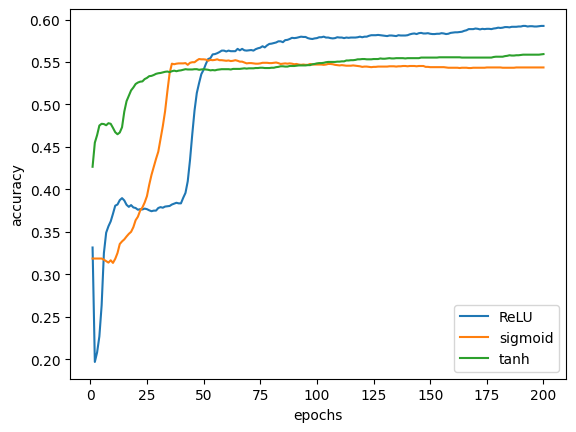

In [ ]:
plt.figure()
for i in range(3):
  plt.plot([j for j in range(1,epochs+1)],epoch_accs[i],label=activators[i])
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [ ]:
clf_random=MLP(epochs,rate,nodes,'random','ReLU')
clf_random.fit(x_train,y_train)
epoch_accs_random=clf_random.epoch_accuracies()
y_pred_random=clf_random.pred(x_test)
print("accuracy for random initialization:",accuracy_score(y_test, y_pred_random))

accuracy for random initialization: 0.5977653631284916


comparing different initialization methods

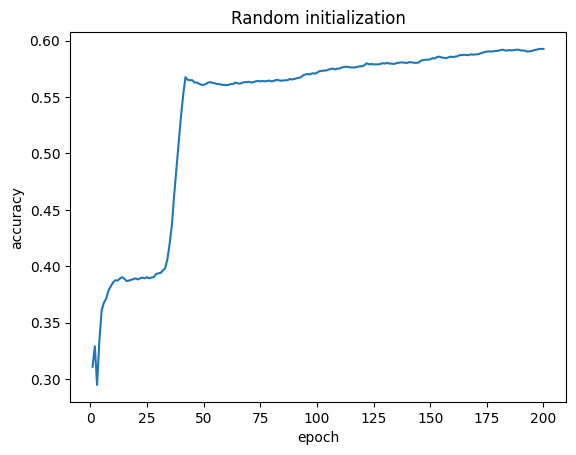

In [ ]:
plt.figure()
plt.plot([j for j in range(1,epochs+1)],epoch_accs_random)
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("Random initialization")
plt.show()

In [ ]:
clf_zero=MLP(epochs,rate,nodes,0,'ReLU')
clf_zero.fit(x_train,y_train)
epoch_accs_zero=clf_zero.epoch_accuracies()
y_pred_zero=clf_zero.pred(x_test)
print("accuracy for zero initialization:",accuracy_score(y_test, y_pred_zero))

accuracy for zero initialization: 0.33679169992019153


Text(0.5, 1.0, 'zero initialization')

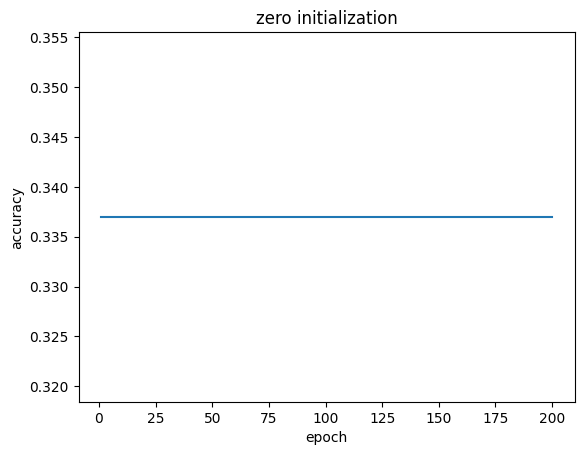

In [ ]:
plt.plot([j for j in range(1,epochs+1)],epoch_accs_zero)
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("zero initialization")

In [ ]:
c=0.1
const_accs=[]
while(c<1):
  clf_const=MLP(epochs,rate,nodes,c,'ReLU')
  clf_const.fit(x_train,y_train)
  y_pred_const=clf_const.pred(x_test)
  const_accs.append(accuracy_score(y_test, y_pred_const))
  print("accuracy for initialization with constant value of",c,"is :",accuracy_score(y_test, y_pred_const))
  c+=0.1

accuracy for initialization with constant value of 0.1 is : 0.33679169992019153
accuracy for initialization with constant value of 0.2 is : 0.33679169992019153
accuracy for initialization with constant value of 0.30000000000000004 is : 0.33679169992019153
accuracy for initialization with constant value of 0.4 is : 0.33679169992019153
accuracy for initialization with constant value of 0.5 is : 0.33679169992019153
accuracy for initialization with constant value of 0.6 is : 0.33679169992019153
accuracy for initialization with constant value of 0.7 is : 0.33679169992019153
accuracy for initialization with constant value of 0.7999999999999999 is : 0.33679169992019153
accuracy for initialization with constant value of 0.8999999999999999 is : 0.33679169992019153
accuracy for initialization with constant value of 0.9999999999999999 is : 0.33679169992019153


In [ ]:
clf_const=MLP(epochs,rate,nodes,0.1,'ReLU')
clf_const.fit(x_train,y_train)
epoch_accs_const=clf_const.epoch_accuracies()

Text(0.5, 1.0, 'constant(0.1) initialization')

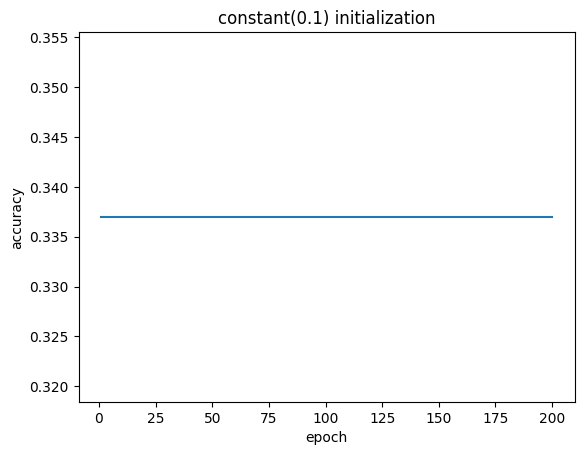

In [ ]:
plt.plot([j for j in range(1,epochs+1)],epoch_accs_const)
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("constant(0.1) initialization")

variation of accuracy with number of nodes

In [ ]:
accs_nodes=[]
for n in range(10,251,10):
  clf=MLP(epochs,rate,n,'random','ReLU')
  clf.fit(x_train,y_train)
  y_pred=clf.pred(x_test)
  accs_nodes.append(accuracy_score(y_test,y_pred))

Text(0.5, 1.0, 'nodes v/s accuracy')

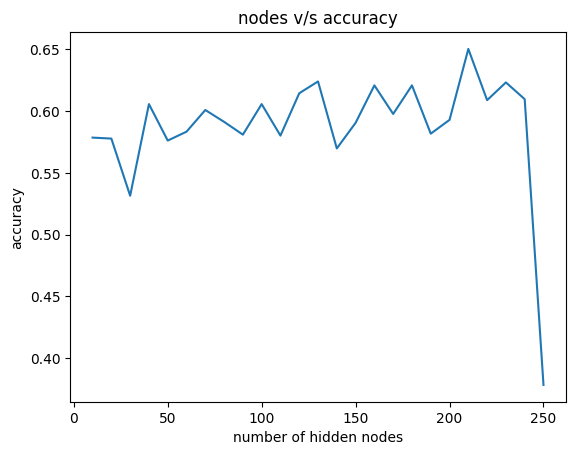

In [ ]:
plt.plot([j for j in range(10,251,10)],accs_nodes)
plt.xlabel("number of hidden nodes")
plt.ylabel("accuracy")
plt.title("nodes v/s accuracy")

storing weights and biases

In [ ]:
import pickle
dbase = open('B21AI044.pickle','wb')
mlp_variables = [clf_random.w1, clf_random.b1, clf_random.w2, clf_random.b2]
pickle.dump(mlp_variables, dbase)
dbase.close()

In [ ]:
dbase = open('B21AI044.pickle','rb')

mlp_loaded_vars = pickle.load(dbase)
dbase.close()
print(mlp_loaded_vars)

[array([[-0.04684889,  0.12789028,  0.1415846 , -0.21066748, -0.16017715,
        -0.41666866,  0.24900073,  0.19060771],
       [ 0.21867264, -0.14442358, -0.00607906, -0.49203922,  0.41892665,
        -0.11073809, -0.08794832, -0.27262435],
       [ 0.00147698,  0.16575914,  0.14780757,  0.0552382 ,  0.41748946,
        -0.4233446 , -0.43771076,  0.48894654],
       [ 0.14842901,  0.10292797, -0.1960611 ,  0.32015281,  0.45400135,
         0.49198728,  0.06098552, -0.33670496],
       [ 0.17603153,  0.48202268, -0.38980089,  0.17655902, -0.23985986,
        -0.00534258, -0.39620816, -0.2044243 ],
       [ 0.42290468,  0.22903723, -0.23821141,  0.17860759, -0.06732375,
        -0.03314216, -0.10436975, -0.07137315],
       [ 0.16675405, -0.19798679,  0.17735383, -0.33453783,  0.56014049,
         0.29346539,  0.33569439,  0.16782785],
       [-0.18395847,  0.0623672 ,  0.16400032,  0.28800672,  0.31242176,
        -0.10328589,  0.44312935,  0.29493243],
       [ 0.38255403,  0.0039895

loading weights and biases

In [ ]:
mlp_loaded=MLP(epochs,rate,nodes,'random','ReLU')
mlp_loaded.w1,mlp_loaded.b1,mlp_loaded.w2,mlp_loaded.b2=mlp_loaded_vars